In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url, header=0, parse_dates=['Date'], index_col='Date')
data = data[['Temp']]

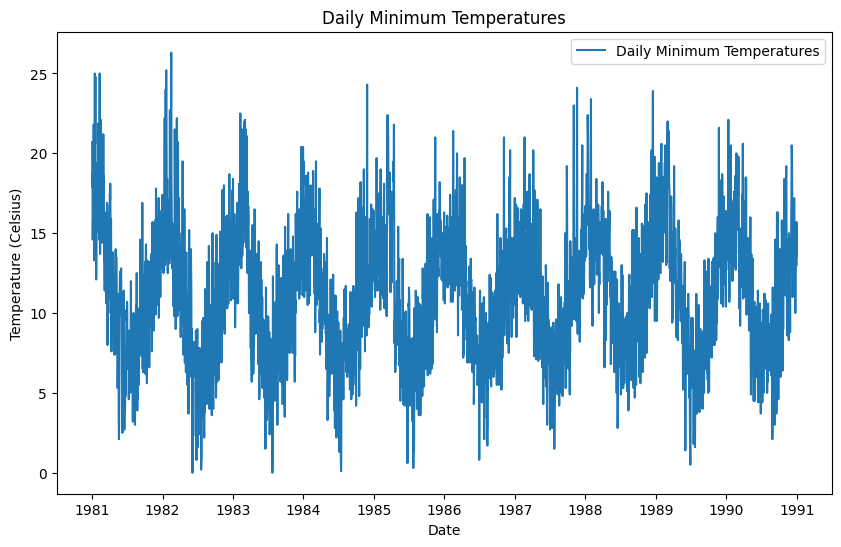

In [4]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Daily Minimum Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.title('Daily Minimum Temperatures')
plt.legend()
plt.show()

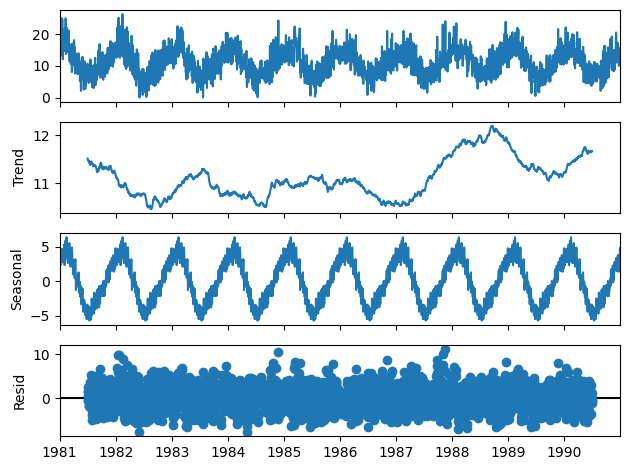

In [5]:
# Decompose the time series
decomposition = seasonal_decompose(data, model='additive', period=365)
decomposition.plot()
plt.show()


In [6]:
# Test for stationarity
result = adfuller(data['Temp'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.444805
p-value: 0.000247


In [7]:
# Differencing to make the series stationary
data_diff = data.diff().dropna()

In [8]:
# Train-test split
train_size = int(len(data) * 0.8)
train, test = data_diff[:train_size], data_diff[train_size:]


In [9]:
# ARIMA model
arima_model = ARIMA(train, order=(5,1,0))
arima_result = arima_model.fit()
print(arima_result.summary())

C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 2920
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7347.251
Date:                Sat, 13 Jul 2024   AIC                          14706.501
Time:                        03:02:27   BIC                          14742.375
Sample:                             0   HQIC                         14719.423
                               - 2920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9880      0.017    -58.971      0.000      -1.021      -0.955
ar.L2         -0.9609      0.022    -44.058      0.000      -1.004      -0.918
ar.L3         -0.7752      0.025    -31.295      0.0

C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


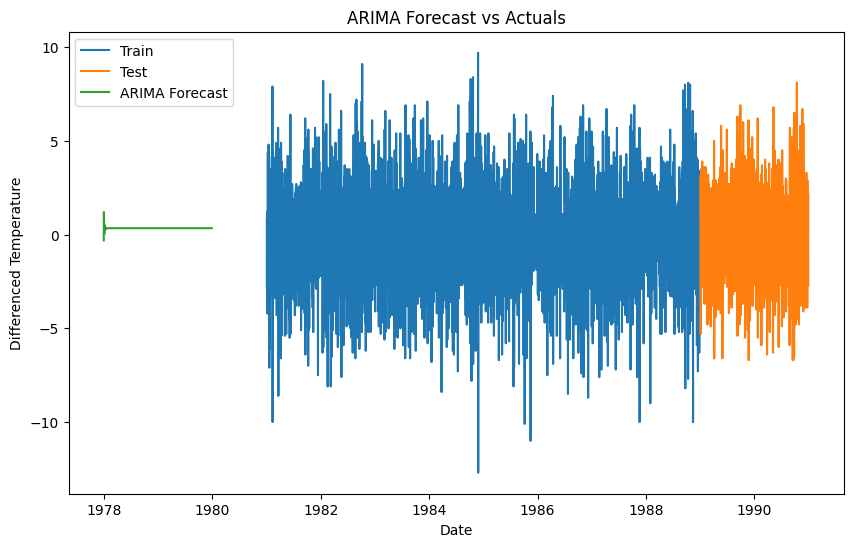

In [10]:
# Forecast
arima_forecast = arima_result.forecast(steps=len(test))
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Differenced Temperature')
plt.title('ARIMA Forecast vs Actuals')
plt.legend()
plt.show()

In [11]:
# Rescale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [12]:
# Prepare data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [13]:
look_back = 1
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [14]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [15]:
# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2918/2918 - 6s - 2ms/step - loss: 0.0143
Epoch 2/20
2918/2918 - 5s - 2ms/step - loss: 0.0104
Epoch 3/20
2918/2918 - 4s - 1ms/step - loss: 0.0103
Epoch 4/20
2918/2918 - 3s - 1ms/step - loss: 0.0103
Epoch 5/20
2918/2918 - 3s - 1ms/step - loss: 0.0104
Epoch 6/20
2918/2918 - 3s - 1ms/step - loss: 0.0103
Epoch 7/20
2918/2918 - 4s - 1ms/step - loss: 0.0103
Epoch 8/20
2918/2918 - 4s - 1ms/step - loss: 0.0103
Epoch 9/20
2918/2918 - 4s - 1ms/step - loss: 0.0103
Epoch 10/20
2918/2918 - 4s - 1ms/step - loss: 0.0102
Epoch 11/20
2918/2918 - 3s - 1ms/step - loss: 0.0103
Epoch 12/20
2918/2918 - 3s - 1ms/step - loss: 0.0102
Epoch 13/20
2918/2918 - 4s - 1ms/step - loss: 0.0102
Epoch 14/20
2918/2918 - 4s - 1ms/step - loss: 0.0102
Epoch 15/20
2918/2918 - 4s - 1ms/step - loss: 0.0102
Epoch 16/20
2918/2918 - 4s - 1ms/step - loss: 0.0102
Epoch 17/20
2918/2918 - 3s - 1ms/step - loss: 0.0102
Epoch 18/20
2918/2918 - 3s - 1ms/step - loss: 0.0102
Epoch 19/20
2918/2918 - 3s - 1ms/step - loss: 0.0102
Ep

In [16]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [17]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [18]:
# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.38 RMSE


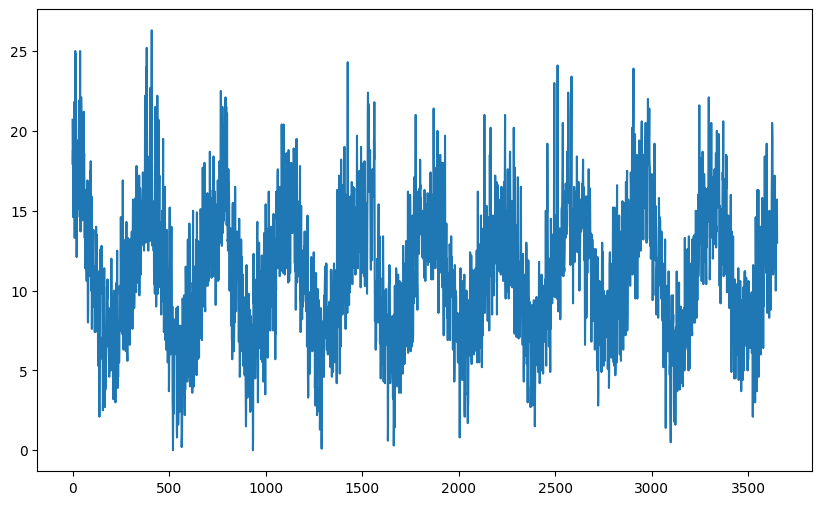

In [19]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(data.values, label='Original data')
trainPredictPlot = np.empty_like(data.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [20]:
testPredictPlot = np.empty_like(data.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict


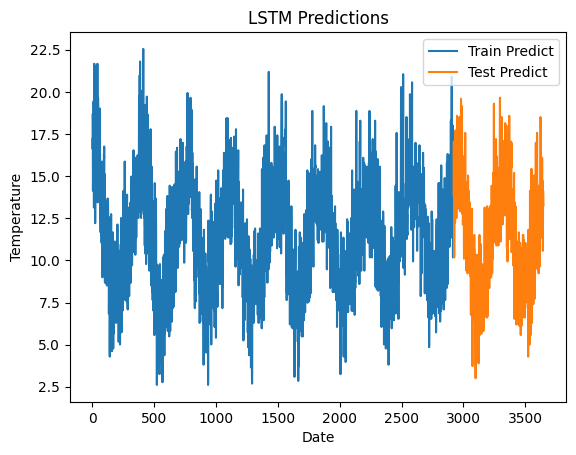

In [21]:
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('LSTM Predictions')
plt.legend()
plt.show()